In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models
import cv2
import sys
import math
import random
import splitfolders
import torchsummary
from tqdm import tqdm
from ResNet_18 import resnet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':150,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':16,
    'SEED':42
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [5]:
# train_df = pd.read_csv('./train_rp_data.csv')
# test_df = pd.read_csv('./test_rp_data.csv')

In [6]:
# for i in range(len(train_df)):
#     if 'user01' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user01'
#     if 'user02' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user02'
#     if 'user03' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user03'
#     if 'user04' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user04'
#     if 'user05' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user05'
#     if 'user06' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user06'
#     if 'user07' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user07'
#     if 'user08' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user08'
#     if 'user09' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user09'
#     if 'user10' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user10'
#     if 'user11' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user11'
#     if 'user12' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user12'
#     if 'user21' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user21'
#     if 'user22' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user22'
#     if 'user23' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user23'
#     if 'user24' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user24'
#     if 'user25' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user25'
#     if 'user26' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user26'
#     if 'user27' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user27'
#     if 'user28' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user28'
#     if 'user29' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user29'
#     if 'user30' in train_df.loc[i]['img_path']:
#         train_df.loc[i, 'user'] = 'user30'

In [7]:
# train_df

In [8]:
# mGps_df = pd.read_csv('./mGps_data.csv', index_col = 0)
# mGps_df

In [9]:
# tmp_df = pd.merge(train_df, mGps_df, on='ts', how='inner')
# tmp_df

In [10]:
# tmp_df.drop(tmp_df[tmp_df['user_x'] != tmp_df['user_y']].index, inplace=True)
# tmp_df

In [11]:
# tmp_df['user_x'].value_counts()

In [12]:
# tmp_df['action'].value_counts()

In [13]:
# train_df['action'].value_counts()

In [14]:
# for i in range(len(test_df)):
#     if 'user01' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user01'
#     if 'user02' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user02'
#     if 'user03' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user03'
#     if 'user04' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user04'
#     if 'user05' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user05'
#     if 'user06' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user06'
#     if 'user07' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user07'
#     if 'user08' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user08'
#     if 'user09' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user09'
#     if 'user10' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user10'
#     if 'user11' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user11'
#     if 'user12' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user12'
#     if 'user21' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user21'
#     if 'user22' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user22'
#     if 'user23' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user23'
#     if 'user24' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user24'
#     if 'user25' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user25'
#     if 'user26' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user26'
#     if 'user27' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user27'
#     if 'user28' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user28'
#     if 'user29' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user29'
#     if 'user30' in test_df.loc[i]['img_path']:
#         test_df.loc[i, 'user'] = 'user30'

In [15]:
# tmp_df2 = pd.merge(test_df, mGps_df, on='ts', how='inner')
# tmp_df2

In [16]:
# tmp_df2.drop(tmp_df2[tmp_df2['user_x'] != tmp_df2['user_y']].index, inplace=True)
# tmp_df2

In [17]:
# tmp_df = tmp_df.drop('user_y', axis=1)
# tmp_df.rename(columns={'user_x':'user'})

In [18]:
# tmp_df2 = tmp_df2.drop('user_y', axis=1)
# tmp_df2.rename(columns={'user_x':'user'})

In [19]:
# tmp_df.to_csv('tmp_train.csv')
# tmp_df2.to_csv('tmp_test.csv')

In [20]:
train_df = pd.read_csv('./tmp_train.csv', index_col = 0)
test_df = pd.read_csv('./tmp_test.csv', index_col = 0)

In [21]:
train_df['action'].value_counts()

work                     10764
travel                    2745
meal                      2259
socialising               1658
outdoor_act               1288
recreation_media          1239
household                 1188
personal_care             1080
shop                       854
entertainment              589
recreation_etc             570
sleep                      241
study                      178
community_interaction       70
hobby                       68
Name: action, dtype: int64

In [22]:
test_df['action'].value_counts()

work                     1225
travel                    313
meal                      260
socialising               180
household                 134
outdoor_act               129
recreation_media          128
personal_care             126
shop                       95
entertainment              71
recreation_etc             62
study                      26
sleep                      25
community_interaction      15
hobby                      10
Name: action, dtype: int64

In [23]:
train_df

,ts,action,img_path,user_x,lat,lon
7,1.600765e+09,work,./ETRI_data_RP_png/user02/1600700400/RP/160076...,user02,37.521518,127.032711
13,1.600765e+09,work,./ETRI_data_RP_png/user04/1600726800/RP/160076...,user04,37.477692,127.122387
21,1.600250e+09,travel,./ETRI_data_RP_png/user04/1600207800/RP/160025...,user04,37.475682,127.127883
25,1.599736e+09,household,./ETRI_data_RP_png/user04/1599690000/RP/159973...,user04,37.435011,127.138813
38,1.600651e+09,work,./ETRI_data_RP_png/user04/1600640400/RP/160065...,user04,37.477842,127.122329
...,...,...,...,...,...,...
196726,1.599208e+09,work,./ETRI_data_RP_png/user04/1599174600/RP/159920...,user04,37.477736,127.122746
196729,1.599792e+09,work,./ETRI_data_RP_png/user04/1599776160/RP/159979...,user04,37.465773,127.126981
196731,1.598840e+09,work,./ETRI_data_RP_png/user04/1598828400/RP/159883...,user04,37.533329,127.142002
196736,1.600221e+09,work,./ETRI_data_RP_png/user04/1600207800/RP/160022...,user04,37.477694,127.122396


In [24]:
test_df

,ts,action,img_path,user_x,lat,lon
13,1.599979e+09,outdoor_act,./ETRI_data_RP_png/user04/1599957060/RP/159997...,user04,37.434939,127.138877
22,1.599040e+09,socialising,./ETRI_data_RP_png/user02/1598972400/RP/159903...,user02,37.521560,127.032720
24,1.598921e+09,work,./ETRI_data_RP_png/user02/1598886000/RP/159892...,user02,37.521576,127.032770
28,1.600693e+09,travel,./ETRI_data_RP_png/user04/1600640400/RP/160069...,user04,37.440471,127.146305
37,1.601116e+09,shop,./ETRI_data_RP_png/user12/1601076000/RP/160111...,user12,37.614593,126.928336
...,...,...,...,...,...,...
22007,1.600049e+09,work,./ETRI_data_RP_png/user04/1600035000/RP/160004...,user04,37.477693,127.122527
22014,1.601011e+09,work,./ETRI_data_RP_png/user04/1600986000/RP/160101...,user04,37.477689,127.122666
22016,1.598921e+09,work,./ETRI_data_RP_png/user02/1598886000/RP/159892...,user02,37.521573,127.032773
22027,1.598914e+09,meal,./ETRI_data_RP_png/user04/1598912400/RP/159891...,user04,37.434961,127.138858


In [25]:
le = LabelEncoder()
le = le.fit(train_df['action'])
train_df['action'] = le.transform(train_df['action'])
test_df['action'] = le.transform(test_df['action'])

In [26]:
img_path_list = []
for i in range(15):
    path_list = list(train_df[train_df['action']==i]['img_path'])
    if len(path_list) >= 3000:
        tmp = random.sample(path_list, 3000)
        for i in tmp:
            img_path_list.append(i)
    else:
        for i in path_list:
            img_path_list.append(i)
df = pd.DataFrame(img_path_list)
df.columns = ['img_path']
df

path_label_df = pd.merge(train_df, df, on='img_path', how='inner')
path_label_df

,ts,action,img_path,user_x,lat,lon
0,1.600250e+09,13,./ETRI_data_RP_png/user04/1600207800/RP/160025...,user04,37.475682,127.127883
1,1.599736e+09,3,./ETRI_data_RP_png/user04/1599690000/RP/159973...,user04,37.435011,127.138813
2,1.599734e+09,4,./ETRI_data_RP_png/user04/1599690000/RP/159973...,user04,37.434953,127.138873
3,1.599105e+09,4,./ETRI_data_RP_png/user04/1599085500/RP/159910...,user04,37.478068,127.121154
4,1.599105e+09,4,./ETRI_data_RP_png/user02/1599058800/RP/159910...,user02,37.523280,127.028385
...,...,...,...,...,...,...
17022,1.600259e+09,13,./ETRI_data_RP_png/user04/1600207800/RP/160025...,user04,37.481122,127.142370
17023,1.599795e+09,4,./ETRI_data_RP_png/user04/1599776160/RP/159979...,user04,37.434940,127.138863
17024,1.599090e+09,14,./ETRI_data_RP_png/user04/1599085500/RP/159909...,user04,37.477714,127.122898
17025,1.599208e+09,14,./ETRI_data_RP_png/user04/1599174600/RP/159920...,user04,37.477736,127.122746


In [27]:
path_label_df['action'].value_counts()

14    3000
13    2745
4     2259
11    1658
5     1288
8     1239
3     1188
6     1080
9      854
1      589
7      570
10     241
12     178
0       70
2       68
Name: action, dtype: int64

In [28]:
train_df = path_label_df
train_df

,ts,action,img_path,user_x,lat,lon
0,1.600250e+09,13,./ETRI_data_RP_png/user04/1600207800/RP/160025...,user04,37.475682,127.127883
1,1.599736e+09,3,./ETRI_data_RP_png/user04/1599690000/RP/159973...,user04,37.435011,127.138813
2,1.599734e+09,4,./ETRI_data_RP_png/user04/1599690000/RP/159973...,user04,37.434953,127.138873
3,1.599105e+09,4,./ETRI_data_RP_png/user04/1599085500/RP/159910...,user04,37.478068,127.121154
4,1.599105e+09,4,./ETRI_data_RP_png/user02/1599058800/RP/159910...,user02,37.523280,127.028385
...,...,...,...,...,...,...
17022,1.600259e+09,13,./ETRI_data_RP_png/user04/1600207800/RP/160025...,user04,37.481122,127.142370
17023,1.599795e+09,4,./ETRI_data_RP_png/user04/1599776160/RP/159979...,user04,37.434940,127.138863
17024,1.599090e+09,14,./ETRI_data_RP_png/user04/1599085500/RP/159909...,user04,37.477714,127.122898
17025,1.599208e+09,14,./ETRI_data_RP_png/user04/1599174600/RP/159920...,user04,37.477736,127.122746


In [29]:
img_path_list = []
for i in range(15):
    path_list = list(test_df[test_df['action']==i]['img_path'])
    if len(path_list) >= 300:
        tmp = random.sample(path_list, 300)
        for i in tmp:
            img_path_list.append(i)
    else:
        for i in path_list:
            img_path_list.append(i)
df = pd.DataFrame(img_path_list)
df.columns = ['img_path']
df

path_label_df = pd.merge(test_df, df, on='img_path', how='inner')
path_label_df

,ts,action,img_path,user_x,lat,lon
0,1.599979e+09,5,./ETRI_data_RP_png/user04/1599957060/RP/159997...,user04,37.434939,127.138877
1,1.599040e+09,11,./ETRI_data_RP_png/user02/1598972400/RP/159903...,user02,37.521560,127.032720
2,1.600693e+09,13,./ETRI_data_RP_png/user04/1600640400/RP/160069...,user04,37.440471,127.146305
3,1.601116e+09,9,./ETRI_data_RP_png/user12/1601076000/RP/160111...,user12,37.614593,126.928336
4,1.599298e+09,7,./ETRI_data_RP_png/user04/1599261300/RP/159929...,user04,35.142077,126.794049
...,...,...,...,...,...,...
1856,1.599861e+09,8,./ETRI_data_RP_png/user04/1599859800/RP/159986...,user04,37.434965,127.138895
1857,1.600326e+09,13,./ETRI_data_RP_png/user04/1600294800/RP/160032...,user04,37.434671,127.138268
1858,1.600049e+09,14,./ETRI_data_RP_png/user04/1600035000/RP/160004...,user04,37.477693,127.122527
1859,1.598914e+09,4,./ETRI_data_RP_png/user04/1598912400/RP/159891...,user04,37.434961,127.138858


In [30]:
path_label_df['action'].value_counts()

13    300
14    300
4     260
11    180
3     134
5     129
8     128
6     126
9      95
1      71
7      62
12     26
10     25
0      15
2      10
Name: action, dtype: int64

In [31]:
test_df = path_label_df
test_df

,ts,action,img_path,user_x,lat,lon
0,1.599979e+09,5,./ETRI_data_RP_png/user04/1599957060/RP/159997...,user04,37.434939,127.138877
1,1.599040e+09,11,./ETRI_data_RP_png/user02/1598972400/RP/159903...,user02,37.521560,127.032720
2,1.600693e+09,13,./ETRI_data_RP_png/user04/1600640400/RP/160069...,user04,37.440471,127.146305
3,1.601116e+09,9,./ETRI_data_RP_png/user12/1601076000/RP/160111...,user12,37.614593,126.928336
4,1.599298e+09,7,./ETRI_data_RP_png/user04/1599261300/RP/159929...,user04,35.142077,126.794049
...,...,...,...,...,...,...
1856,1.599861e+09,8,./ETRI_data_RP_png/user04/1599859800/RP/159986...,user04,37.434965,127.138895
1857,1.600326e+09,13,./ETRI_data_RP_png/user04/1600294800/RP/160032...,user04,37.434671,127.138268
1858,1.600049e+09,14,./ETRI_data_RP_png/user04/1600035000/RP/160004...,user04,37.477693,127.122527
1859,1.598914e+09,4,./ETRI_data_RP_png/user04/1598912400/RP/159891...,user04,37.434961,127.138858


In [ ]:
# train_df[train_df['action']==14]

In [ ]:
# path_list = train_df[train_df['action']==14]['img_path']
# pl = list(path_list)

In [ ]:
# tmp = random.sample(pl, 3000)

In [ ]:
# tmp

In [32]:
train, val, _, _ = train_test_split(train_df, train_df['action'], test_size=0.1, random_state=CFG['SEED'], stratify=train_df['action'])

In [36]:
train['action'].value_counts()

14    2700
13    2471
4     2033
11    1492
5     1159
8     1115
3     1069
6      972
9      769
1      530
7      513
10     217
12     160
0       63
2       61
Name: action, dtype: int64

In [38]:
val['action'].value_counts()

14    300
13    274
4     226
11    166
5     129
8     124
3     119
6     108
9      85
1      59
7      57
10     24
12     18
0       7
2       7
Name: action, dtype: int64

In [ ]:
# train, val, _, _ = train_test_split(train_df, train_df['action'], test_size=0.1, random_state=CFG['SEED'])

In [ ]:
train

In [ ]:
val

In [42]:
RP_tfms = A.Compose([
    A.Resize(width=CFG['IMG_SIZE'], height=CFG['IMG_SIZE']),
    A.Normalize()
], p=1)

In [43]:
Gps_tfms = A.Compose([
    A.Resize(width=112, height=112),
    A.Normalize()
], p=1)

In [44]:
class RPDataset(Dataset):
    def __init__(self, df, rp_path_list, label_list, tfms=None):
        super().__init__()
        self.df = df
        self.rp_path_list = rp_path_list
        self.label_list = label_list
        self.tfms = tfms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.rp_path_list[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.tfms(image=img)['image']
        image = torch.tensor(np.array(image)).permute(2, 0, 1)
        
        if self.label_list is not None:
            label = self.label_list[idx]
            return image, label
        else:
            return image

In [45]:
class GpsDataset(Dataset):
    def __init__(self, df, lat_path_list, lon_path_list, label_list, tfms=None):
        super(GpsDataset, self).__init__()
        self.df = df
        self.lat_path_list = lat_path_list
        self.lon_path_list = lon_path_list
        self.label_list = label_list
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        lat = self.lat_path_list[idx]
        lon = self.lon_path_list[idx]
        feature_map = torch.tensor(np.array([lat, lon]))
        
        if self.label_list is not None:
            label = self.label_list[idx]
            return feature_map, label
        else:
            return feature_map

In [46]:
RP_train_dataset = RPDataset(df=train, rp_path_list=train['img_path'].values, label_list=train['action'].values, tfms=RP_tfms)
RP_train_loader = DataLoader(RP_train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

RP_val_dataset = RPDataset(df=val,rp_path_list=val['img_path'].values, label_list=val['action'].values, tfms=RP_tfms)
RP_val_loader = DataLoader(RP_val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [47]:
Gps_train_dataset = GpsDataset(df=train, lat_path_list=train['lat'].values, lon_path_list=train['lon'].values, label_list=train['action'].values, tfms=Gps_tfms)
Gps_train_loader = DataLoader(Gps_train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

Gps_val_dataset = GpsDataset(df=val, lat_path_list=train['lat'].values, lon_path_list=train['lon'].values, label_list=val['action'].values, tfms=Gps_tfms)
Gps_val_loader = DataLoader(Gps_val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [48]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction=self.reduction)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1-pt)**self.gamma * ce_loss).mean()
        return focal_loss

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        bias=False,
        padding = 1,
        padding_mode='zeros'
    )


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=1,
        stride=stride,
        bias=False,
        padding = 1,
        padding_mode='zeros'
    )


class IdentityBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride = 1):
        super(IdentityBlock, self).__init__()

        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.conv2 = conv3x3(out_planes, out_planes, 1)

        self.bn1   = nn.BatchNorm2d(out_planes)
        self.bn2   = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                conv1x1(in_planes, out_planes, stride),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        identity = x
        out  = self.conv1(x)
        out  = self.bn1(out)
        out  = F.relu(out)
        out  = self.conv2(out)
        out  = self.bn2(out)
        out += identity
        out  = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, in_planes, num_blocks, num_classes):
        super(ResNet, self).__init__()

        self.in_planes = in_planes

        self.conv = nn.Conv2d(3, in_planes, kernel_size = 3, stride = 1, padding = 1, padding_mode='zeros', bias=False)
        self.bn = nn.BatchNorm2d(self.in_planes)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, in_planes, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, in_planes, num_blocks[1], stride=1)
        self.layer3 = self.make_layer(block, in_planes, num_blocks[2], stride=1)
        self.layer4 = self.make_layer(block, in_planes, num_blocks[3], stride=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear  = nn.Linear(in_planes + 2, num_classes)

    def make_layer(self, block, out_planes, num_blocks, stride):
            strides = [stride] + [1] * (num_blocks -1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, out_planes))
                self.in_planes = out_planes
            return nn.Sequential(*layers)

    def forward(self, x, g):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
#         print(out.shape)
        g = g.unsqueeze(-1).unsqueeze(-1)
        g = g.expand(-1, -1, 1, 1).float()
#         g = self.avgpool(g)
#         print(g.shape)
        out = torch.cat((out, g), dim=1)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out


def ResNet18(in_planes, num_classes):
    return ResNet(block = IdentityBlock, in_planes = in_planes, num_blocks = [2, 2, 2, 2], num_classes = num_classes)

In [50]:
def train(model, optimizer, scheduler, device):
    model.to(device)
    criterion = FocalLoss().to(device)
    
    best_val_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for i, data in enumerate(zip(tqdm(RP_train_loader), Gps_train_loader)):
            data1, data2 = data
            images, labels = data1
            gps, _ = data2
            
            images = images.to(device)
            gps = gps.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(images, gps)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
    
    return best_model

In [51]:
def validation(model, criterion, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for i, data in enumerate(zip(tqdm(RP_val_loader), Gps_val_loader)):
            data1, data2 = data
            images, labels = data1
            gps, _ = data2
            
            images = images.to(device)
            gps = gps.to(device)
            labels = labels.to(device)
            
            logit = model(images, gps)
            
            loss = criterion(logit, labels)
            
            val_loss.append(loss.item())
            
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='micro')
    return _val_loss, _val_score

In [52]:
# model = resnet.ResNet18(64, 15)
model = ResNet18(64, 15)
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, scheduler, device)

100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.19it/s]


Epoch [1], Train Loss : [2.97903] Val Loss : [1.74806] Val F1 : [0.28127]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.14it/s]


Epoch [2], Train Loss : [1.69568] Val Loss : [1.65839] Val F1 : [0.30241]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.77it/s]


Epoch [3], Train Loss : [1.63007] Val Loss : [1.58888] Val F1 : [0.32942]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.21it/s]


Epoch [4], Train Loss : [1.58843] Val Loss : [1.57752] Val F1 : [0.32355]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.87it/s]


Epoch [5], Train Loss : [1.55957] Val Loss : [1.53919] Val F1 : [0.33999]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.39it/s]


Epoch [6], Train Loss : [1.52741] Val Loss : [1.52103] Val F1 : [0.35467]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [7], Train Loss : [1.50598] Val Loss : [1.46613] Val F1 : [0.35937]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.69it/s]


Epoch [8], Train Loss : [1.47530] Val Loss : [1.48979] Val F1 : [0.36406]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.01it/s]


Epoch [9], Train Loss : [1.45410] Val Loss : [1.46519] Val F1 : [0.35878]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.86it/s]


Epoch [10], Train Loss : [1.42734] Val Loss : [1.41098] Val F1 : [0.38285]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.77it/s]


Epoch [11], Train Loss : [1.40717] Val Loss : [1.43355] Val F1 : [0.37992]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.81it/s]


Epoch [12], Train Loss : [1.39443] Val Loss : [1.34509] Val F1 : [0.39812]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.78it/s]


Epoch [13], Train Loss : [1.37043] Val Loss : [1.40343] Val F1 : [0.38638]


100%|█████████████████████████████████████████| 107/107 [00:14<00:00,  7.62it/s]


Epoch [14], Train Loss : [1.35369] Val Loss : [1.36068] Val F1 : [0.40223]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  8.94it/s]


Epoch [15], Train Loss : [1.33279] Val Loss : [1.33997] Val F1 : [0.39518]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.67it/s]


Epoch [16], Train Loss : [1.31808] Val Loss : [1.33513] Val F1 : [0.40752]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.53it/s]


Epoch [17], Train Loss : [1.31146] Val Loss : [1.38613] Val F1 : [0.40517]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.57it/s]


Epoch [18], Train Loss : [1.28438] Val Loss : [1.36674] Val F1 : [0.40106]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  7.65it/s]


Epoch [19], Train Loss : [1.28275] Val Loss : [1.31736] Val F1 : [0.40458]
Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.66it/s]


Epoch [20], Train Loss : [1.21260] Val Loss : [1.25448] Val F1 : [0.43511]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.11it/s]


Epoch [21], Train Loss : [1.19082] Val Loss : [1.24755] Val F1 : [0.42983]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.06it/s]


Epoch [22], Train Loss : [1.18006] Val Loss : [1.23371] Val F1 : [0.44510]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.69it/s]


Epoch [23], Train Loss : [1.16648] Val Loss : [1.24282] Val F1 : [0.42924]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [24], Train Loss : [1.15327] Val Loss : [1.27234] Val F1 : [0.42513]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.91it/s]


Epoch [25], Train Loss : [1.14302] Val Loss : [1.24164] Val F1 : [0.43042]
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.74it/s]


Epoch [26], Train Loss : [1.10471] Val Loss : [1.22587] Val F1 : [0.44510]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.58it/s]


Epoch [27], Train Loss : [1.08988] Val Loss : [1.20819] Val F1 : [0.44275]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.22it/s]


Epoch [28], Train Loss : [1.08701] Val Loss : [1.20095] Val F1 : [0.46213]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.78it/s]


Epoch [29], Train Loss : [1.07600] Val Loss : [1.20877] Val F1 : [0.44451]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.68it/s]


Epoch [30], Train Loss : [1.06921] Val Loss : [1.21251] Val F1 : [0.44392]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.83it/s]


Epoch [31], Train Loss : [1.06032] Val Loss : [1.19825] Val F1 : [0.45332]
Epoch 00031: reducing learning rate of group 0 to 1.2500e-05.


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.02it/s]


Epoch [32], Train Loss : [1.02692] Val Loss : [1.19374] Val F1 : [0.45567]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.67it/s]


Epoch [33], Train Loss : [1.03414] Val Loss : [1.18159] Val F1 : [0.46095]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.82it/s]


Epoch [34], Train Loss : [1.02108] Val Loss : [1.19191] Val F1 : [0.45625]
Epoch 00034: reducing learning rate of group 0 to 6.2500e-06.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.77it/s]


Epoch [35], Train Loss : [1.00919] Val Loss : [1.17543] Val F1 : [0.46506]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.79it/s]


Epoch [36], Train Loss : [1.00229] Val Loss : [1.18232] Val F1 : [0.46447]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.34it/s]


Epoch [37], Train Loss : [1.00338] Val Loss : [1.17602] Val F1 : [0.45860]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.07it/s]


Epoch [38], Train Loss : [0.99876] Val Loss : [1.17191] Val F1 : [0.45625]
Epoch 00038: reducing learning rate of group 0 to 3.1250e-06.


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  7.70it/s]


Epoch [39], Train Loss : [0.99048] Val Loss : [1.17150] Val F1 : [0.46213]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.79it/s]


Epoch [40], Train Loss : [0.99211] Val Loss : [1.17090] Val F1 : [0.46389]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  8.94it/s]


Epoch [41], Train Loss : [0.99161] Val Loss : [1.17052] Val F1 : [0.46389]
Epoch 00041: reducing learning rate of group 0 to 1.5625e-06.


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.06it/s]


Epoch [42], Train Loss : [0.98003] Val Loss : [1.17326] Val F1 : [0.46858]


100%|█████████████████████████████████████████| 107/107 [00:14<00:00,  7.57it/s]


Epoch [43], Train Loss : [0.97783] Val Loss : [1.17614] Val F1 : [0.45860]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.77it/s]


Epoch [44], Train Loss : [0.98283] Val Loss : [1.17173] Val F1 : [0.46858]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  8.92it/s]


Epoch [45], Train Loss : [0.97482] Val Loss : [1.17388] Val F1 : [0.46095]
Epoch 00045: reducing learning rate of group 0 to 7.8125e-07.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.84it/s]


Epoch [46], Train Loss : [0.97626] Val Loss : [1.17575] Val F1 : [0.45684]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  8.94it/s]


Epoch [47], Train Loss : [0.97341] Val Loss : [1.17237] Val F1 : [0.45860]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.21it/s]


Epoch [48], Train Loss : [0.98097] Val Loss : [1.17580] Val F1 : [0.46447]
Epoch 00048: reducing learning rate of group 0 to 3.9063e-07.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.25it/s]


Epoch [49], Train Loss : [0.97489] Val Loss : [1.17328] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.88it/s]


Epoch [50], Train Loss : [0.97563] Val Loss : [1.17749] Val F1 : [0.45860]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.81it/s]


Epoch [51], Train Loss : [0.97408] Val Loss : [1.17580] Val F1 : [0.46565]
Epoch 00051: reducing learning rate of group 0 to 1.9531e-07.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.87it/s]


Epoch [52], Train Loss : [0.97395] Val Loss : [1.18478] Val F1 : [0.45919]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.80it/s]


Epoch [53], Train Loss : [0.97476] Val Loss : [1.17758] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.86it/s]


Epoch [54], Train Loss : [0.96874] Val Loss : [1.16941] Val F1 : [0.46389]
Epoch 00054: reducing learning rate of group 0 to 9.7656e-08.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [55], Train Loss : [0.98013] Val Loss : [1.17435] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.89it/s]


Epoch [56], Train Loss : [0.97467] Val Loss : [1.17786] Val F1 : [0.46447]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.72it/s]


Epoch [57], Train Loss : [0.98044] Val Loss : [1.17101] Val F1 : [0.46213]
Epoch 00057: reducing learning rate of group 0 to 4.8828e-08.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.75it/s]


Epoch [58], Train Loss : [0.97608] Val Loss : [1.17068] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.84it/s]


Epoch [59], Train Loss : [0.97480] Val Loss : [1.17782] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.78it/s]


Epoch [60], Train Loss : [0.97504] Val Loss : [1.17521] Val F1 : [0.46036]
Epoch 00060: reducing learning rate of group 0 to 2.4414e-08.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.89it/s]


Epoch [61], Train Loss : [0.97201] Val Loss : [1.17651] Val F1 : [0.46506]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.71it/s]


Epoch [62], Train Loss : [0.96534] Val Loss : [1.17985] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.66it/s]


Epoch [63], Train Loss : [0.96528] Val Loss : [1.17666] Val F1 : [0.45684]
Epoch 00063: reducing learning rate of group 0 to 1.2207e-08.


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.67it/s]


Epoch [64], Train Loss : [0.97730] Val Loss : [1.16894] Val F1 : [0.46330]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.72it/s]


Epoch [65], Train Loss : [0.97266] Val Loss : [1.18104] Val F1 : [0.45919]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.70it/s]


Epoch [66], Train Loss : [0.97539] Val Loss : [1.17960] Val F1 : [0.45802]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  7.83it/s]


Epoch [67], Train Loss : [0.97439] Val Loss : [1.17256] Val F1 : [0.46213]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.72it/s]


Epoch [68], Train Loss : [0.97748] Val Loss : [1.16770] Val F1 : [0.46389]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.72it/s]


Epoch [69], Train Loss : [0.97616] Val Loss : [1.18168] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [70], Train Loss : [0.97171] Val Loss : [1.18062] Val F1 : [0.45919]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  7.86it/s]


Epoch [71], Train Loss : [0.97706] Val Loss : [1.18212] Val F1 : [0.45625]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  7.78it/s]


Epoch [72], Train Loss : [0.97235] Val Loss : [1.17498] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.71it/s]


Epoch [73], Train Loss : [0.97328] Val Loss : [1.17756] Val F1 : [0.46213]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.74it/s]


Epoch [74], Train Loss : [0.97629] Val Loss : [1.17638] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.89it/s]


Epoch [75], Train Loss : [0.97623] Val Loss : [1.17822] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.22it/s]


Epoch [76], Train Loss : [0.97642] Val Loss : [1.18246] Val F1 : [0.45214]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.75it/s]


Epoch [77], Train Loss : [0.97452] Val Loss : [1.18266] Val F1 : [0.45802]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  7.77it/s]


Epoch [78], Train Loss : [0.97072] Val Loss : [1.17769] Val F1 : [0.46271]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.18it/s]


Epoch [79], Train Loss : [0.97696] Val Loss : [1.17712] Val F1 : [0.46213]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.86it/s]


Epoch [80], Train Loss : [0.97394] Val Loss : [1.17382] Val F1 : [0.46389]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.61it/s]


Epoch [81], Train Loss : [0.97663] Val Loss : [1.18771] Val F1 : [0.45332]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.81it/s]


Epoch [82], Train Loss : [0.97289] Val Loss : [1.17284] Val F1 : [0.45449]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.75it/s]


Epoch [83], Train Loss : [0.97409] Val Loss : [1.17279] Val F1 : [0.46330]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.72it/s]


Epoch [84], Train Loss : [0.97288] Val Loss : [1.17322] Val F1 : [0.46447]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.75it/s]


Epoch [85], Train Loss : [0.97022] Val Loss : [1.17552] Val F1 : [0.45860]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.05it/s]


Epoch [86], Train Loss : [0.97728] Val Loss : [1.18057] Val F1 : [0.45978]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  8.92it/s]


Epoch [87], Train Loss : [0.97737] Val Loss : [1.17318] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.82it/s]


Epoch [88], Train Loss : [0.97153] Val Loss : [1.18157] Val F1 : [0.46389]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.89it/s]


Epoch [89], Train Loss : [0.97865] Val Loss : [1.17922] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.27it/s]


Epoch [90], Train Loss : [0.96895] Val Loss : [1.18010] Val F1 : [0.46389]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.80it/s]


Epoch [91], Train Loss : [0.97175] Val Loss : [1.17244] Val F1 : [0.45919]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.78it/s]


Epoch [92], Train Loss : [0.96908] Val Loss : [1.17209] Val F1 : [0.45978]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.81it/s]


Epoch [93], Train Loss : [0.97904] Val Loss : [1.16945] Val F1 : [0.46976]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.78it/s]


Epoch [94], Train Loss : [0.97316] Val Loss : [1.17601] Val F1 : [0.45919]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.75it/s]


Epoch [95], Train Loss : [0.97093] Val Loss : [1.18003] Val F1 : [0.45860]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.02it/s]


Epoch [96], Train Loss : [0.96743] Val Loss : [1.17768] Val F1 : [0.45978]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.55it/s]


Epoch [97], Train Loss : [0.97521] Val Loss : [1.17529] Val F1 : [0.45802]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.86it/s]


Epoch [98], Train Loss : [0.97339] Val Loss : [1.18266] Val F1 : [0.45860]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.16it/s]


Epoch [99], Train Loss : [0.97324] Val Loss : [1.18465] Val F1 : [0.45332]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.75it/s]


Epoch [100], Train Loss : [0.97149] Val Loss : [1.17208] Val F1 : [0.45978]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.79it/s]


Epoch [101], Train Loss : [0.97657] Val Loss : [1.17666] Val F1 : [0.45567]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [102], Train Loss : [0.97341] Val Loss : [1.18088] Val F1 : [0.45743]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.08it/s]


Epoch [103], Train Loss : [0.97878] Val Loss : [1.17516] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.80it/s]


Epoch [104], Train Loss : [0.97383] Val Loss : [1.17824] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.80it/s]


Epoch [105], Train Loss : [0.97719] Val Loss : [1.17625] Val F1 : [0.46624]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.90it/s]


Epoch [106], Train Loss : [0.97498] Val Loss : [1.17900] Val F1 : [0.45743]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  7.97it/s]


Epoch [107], Train Loss : [0.97774] Val Loss : [1.17435] Val F1 : [0.46213]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.75it/s]


Epoch [108], Train Loss : [0.97962] Val Loss : [1.18192] Val F1 : [0.45508]


100%|█████████████████████████████████████████| 107/107 [00:14<00:00,  7.63it/s]


Epoch [109], Train Loss : [0.96666] Val Loss : [1.17333] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.74it/s]


Epoch [110], Train Loss : [0.97492] Val Loss : [1.17156] Val F1 : [0.46389]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.80it/s]


Epoch [111], Train Loss : [0.97451] Val Loss : [1.17883] Val F1 : [0.46741]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.54it/s]


Epoch [112], Train Loss : [0.96998] Val Loss : [1.17176] Val F1 : [0.46682]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.00it/s]


Epoch [113], Train Loss : [0.96993] Val Loss : [1.18017] Val F1 : [0.46917]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.56it/s]


Epoch [114], Train Loss : [0.97014] Val Loss : [1.18297] Val F1 : [0.45743]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.75it/s]


Epoch [115], Train Loss : [0.97496] Val Loss : [1.17874] Val F1 : [0.45743]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.30it/s]


Epoch [116], Train Loss : [0.97544] Val Loss : [1.17581] Val F1 : [0.45390]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.78it/s]


Epoch [117], Train Loss : [0.97010] Val Loss : [1.18237] Val F1 : [0.46095]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.60it/s]


Epoch [118], Train Loss : [0.97234] Val Loss : [1.17822] Val F1 : [0.45919]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [119], Train Loss : [0.96585] Val Loss : [1.17048] Val F1 : [0.46506]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.78it/s]


Epoch [120], Train Loss : [0.97479] Val Loss : [1.17640] Val F1 : [0.46330]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.80it/s]


Epoch [121], Train Loss : [0.97605] Val Loss : [1.17557] Val F1 : [0.46095]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  8.21it/s]


Epoch [122], Train Loss : [0.97060] Val Loss : [1.17147] Val F1 : [0.46271]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.85it/s]


Epoch [123], Train Loss : [0.97360] Val Loss : [1.16867] Val F1 : [0.46565]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.77it/s]


Epoch [124], Train Loss : [0.97176] Val Loss : [1.17138] Val F1 : [0.46506]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.90it/s]


Epoch [125], Train Loss : [0.96716] Val Loss : [1.17219] Val F1 : [0.46565]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [126], Train Loss : [0.97236] Val Loss : [1.18401] Val F1 : [0.46389]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.63it/s]


Epoch [127], Train Loss : [0.97367] Val Loss : [1.17393] Val F1 : [0.46213]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [128], Train Loss : [0.97695] Val Loss : [1.16903] Val F1 : [0.46213]


100%|█████████████████████████████████████████| 107/107 [00:14<00:00,  7.60it/s]


Epoch [129], Train Loss : [0.97672] Val Loss : [1.17604] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.74it/s]


Epoch [130], Train Loss : [0.97646] Val Loss : [1.17467] Val F1 : [0.46095]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.80it/s]


Epoch [131], Train Loss : [0.96971] Val Loss : [1.17772] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.73it/s]


Epoch [132], Train Loss : [0.97210] Val Loss : [1.18465] Val F1 : [0.45273]


100%|█████████████████████████████████████████| 107/107 [00:13<00:00,  7.88it/s]


Epoch [133], Train Loss : [0.97456] Val Loss : [1.17436] Val F1 : [0.46389]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.29it/s]


Epoch [134], Train Loss : [0.96909] Val Loss : [1.17435] Val F1 : [0.46330]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.49it/s]


Epoch [135], Train Loss : [0.97519] Val Loss : [1.17406] Val F1 : [0.46565]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.72it/s]


Epoch [136], Train Loss : [0.96907] Val Loss : [1.16876] Val F1 : [0.46682]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


Epoch [137], Train Loss : [0.96892] Val Loss : [1.17221] Val F1 : [0.45919]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.71it/s]


Epoch [138], Train Loss : [0.97200] Val Loss : [1.17062] Val F1 : [0.46565]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.86it/s]


Epoch [139], Train Loss : [0.97189] Val Loss : [1.18072] Val F1 : [0.46506]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.68it/s]


Epoch [140], Train Loss : [0.97197] Val Loss : [1.18372] Val F1 : [0.45978]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.03it/s]


Epoch [141], Train Loss : [0.97820] Val Loss : [1.17511] Val F1 : [0.46154]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.01it/s]


Epoch [142], Train Loss : [0.97144] Val Loss : [1.17711] Val F1 : [0.45978]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.87it/s]


Epoch [143], Train Loss : [0.97369] Val Loss : [1.17638] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.89it/s]


Epoch [144], Train Loss : [0.97012] Val Loss : [1.17177] Val F1 : [0.45860]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.72it/s]


Epoch [145], Train Loss : [0.97313] Val Loss : [1.17616] Val F1 : [0.45919]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.85it/s]


Epoch [146], Train Loss : [0.96908] Val Loss : [1.17811] Val F1 : [0.46036]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.79it/s]


Epoch [147], Train Loss : [0.96992] Val Loss : [1.17563] Val F1 : [0.46682]


100%|█████████████████████████████████████████| 107/107 [00:11<00:00,  9.00it/s]


Epoch [148], Train Loss : [0.96849] Val Loss : [1.18138] Val F1 : [0.46682]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.73it/s]


Epoch [149], Train Loss : [0.96754] Val Loss : [1.17498] Val F1 : [0.46095]


100%|█████████████████████████████████████████| 107/107 [00:12<00:00,  8.90it/s]

Epoch [150], Train Loss : [0.97738] Val Loss : [1.18374] Val F1 : [0.46095]


In [53]:
RP_test_dataset = RPDataset(df=test_df, rp_path_list=test_df['img_path'].values, label_list=test_df['action'].values, tfms=RP_tfms)
RP_test_loader = DataLoader(RP_test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

Gps_test_dataset = GpsDataset(df=test_df, lat_path_list=test_df['lat'].values, lon_path_list=test_df['lon'].values, label_list=test_df['action'].values, tfms=Gps_tfms)
Gps_test_loader = DataLoader(Gps_test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

In [54]:
def inference(model, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for i, data in enumerate(zip(tqdm(RP_test_loader), Gps_test_loader)):
            data1, data2 = data
            images, labels = data1
            gps, _ = data2
            
            images = images.to(device)
            gps = gps.to(device)
            labels = labels.to(device)
            
            logit = model(images, gps)
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

In [55]:
preds = inference(model, device)

100%|█████████████████████████████████████████| 117/117 [00:14<00:00,  8.21it/s]


In [56]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(test_df['action'], preds, labels=[x for x in range(0, 15)])
confusion_matrix

array([[  0,   1,   0,   0,   1,   1,   4,   0,   1,   1,   0,   1,   0,
          5,   0],
       [  0,  24,   0,   1,   4,   3,   6,   0,   2,   2,   0,   7,   0,
          8,  14],
       [  0,   0,   0,   0,   1,   0,   0,   0,   2,   0,   0,   3,   0,
          0,   4],
       [  0,   1,   0,  41,  12,   6,   7,   0,  10,   2,   0,   9,   0,
         18,  28],
       [  0,   2,   0,  31,  86,   7,  10,   0,  19,   7,   1,  20,   0,
         32,  45],
       [  0,   1,   0,  10,   8,  85,   1,   0,   3,   0,   0,   3,   0,
         12,   6],
       [  1,   5,   0,  12,  11,   3,  46,   0,   5,   5,   4,   8,   0,
         11,  15],
       [  0,   0,   0,   3,   3,   1,   4,   9,  12,   1,   3,   5,   0,
          7,  14],
       [  0,   1,   0,   6,  21,   1,   4,   1,  42,   1,   1,   3,   0,
          7,  40],
       [  0,   4,   0,   4,  12,   6,  10,   0,   8,  15,   0,   7,   0,
         20,   9],
       [  0,   2,   0,   3,   1,   0,   2,   1,   2,   0,  10,   0,   0,
       

<Axes: title={'center': 'Confusion Matrix'}>

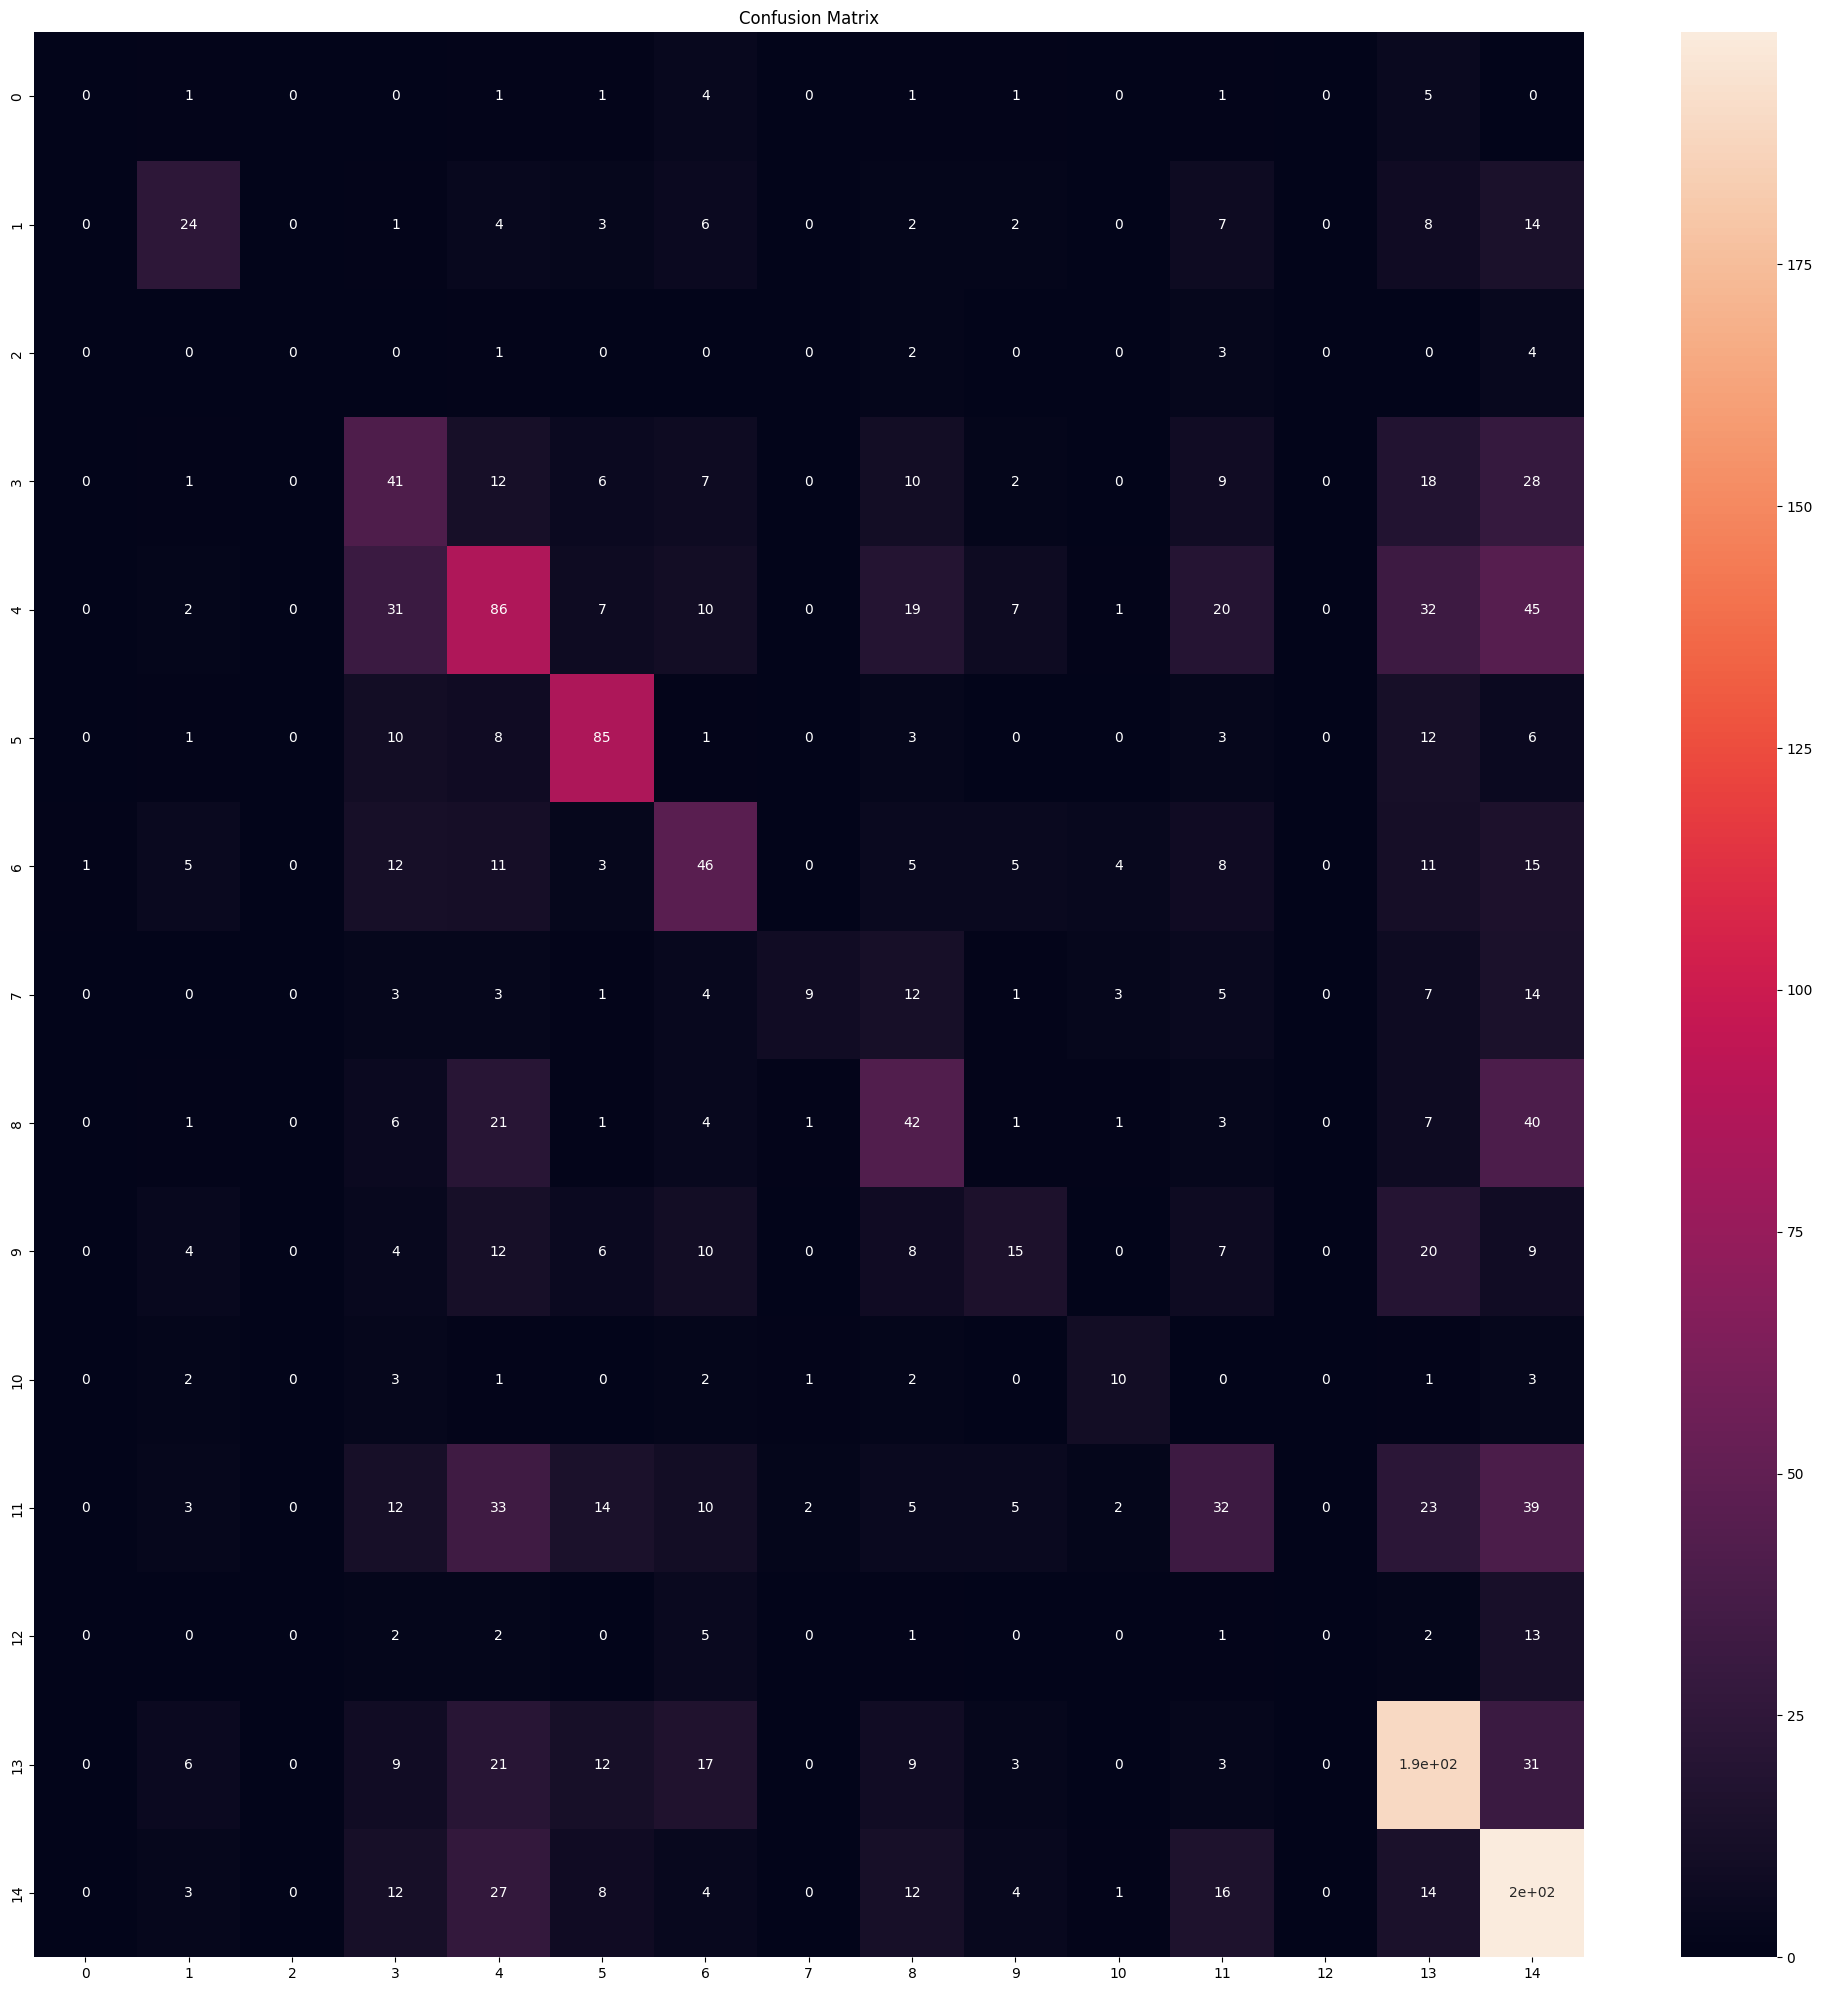

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (25,25))
plt.title('Confusion Matrix')

sns.heatmap(confusion_matrix, annot=True)

In [58]:
from sklearn.metrics import f1_score 
f1 = f1_score(test_df['action'], preds, average='micro')
print('F1-score: {0:.4f}'.format(f1))

F1-score: 0.4181


In [59]:
torch.save(model, f'./save_model/0409_RPmGps.pt')